首先读取数据

In [30]:
import pickle
import sys
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import random
import numpy as np
import matplotlib.pyplot as plt
from filterpy.kalman import KalmanFilter
plt.rcParams['font.family'] = ['Simhei']  # 中文显示

设置相应的超参数

In [31]:
d1,d2=2500,2500
w1,w2=40,40


window_size = 100  # 窗口大小,导致线平缓度
poly_order = 4    # 多项式阶数

# 设置Kalman滤波器的测量噪声和过程噪声
measurement_noise = 20
process_noise = 0.1

In [32]:

#由你的电脑的屏幕大小来决定
screen_width,screen_height=2560,1600

#print(screen_wide,screen_high  )

def read_data(d1,d2,w1,w2):
    '''
    通过D,和W的大小来区分和读取数据，并返回四个数据结果。
    '''
    name=sys.path[0]+'\data\\'+'D='+str(d1)+'-'+str(d2)+'_W='+str(w1)+'-'+str(w2)+".bin"

    with open(name,'rb') as file:
        move_datas=pickle.load(file)
    
    return move_datas

mouse_move=read_data(d1,d2,w1,w2)

In [33]:

T_all=[]
X_all=[]
Y_all=[]
for k in range(len(mouse_move)):
    T=[]
    X=[]
    Y=[]
    for i in range(len(mouse_move[k])):
        #print(mouse_move[0][i])
        T.append(mouse_move[k][i][0]-mouse_move[k][0][0])
        X.append(mouse_move[k][i][1])
        Y.append(mouse_move[k][i][2])   

    # 使用Savitzky-Golay滤波器平滑数据
    
    T_smoothed = savgol_filter(T, window_size, poly_order)
    X_smoothed = savgol_filter(X, window_size, poly_order)
    Y_smoothed = savgol_filter(Y, window_size, poly_order)
    T_all.append(T_smoothed)
    X_all.append(X_smoothed)
    Y_all.append(Y_smoothed)


In [34]:
T=[]
X=[]
Y=[]
for k in range(len(mouse_move)):
    t=[]
    x=[]
    y=[]
    for i in range(len(mouse_move[k])):
        #print(mouse_move[0][i])
        t.append(mouse_move[k][i][0]-mouse_move[k][0][0])
        x.append(mouse_move[k][i][1])
        y.append(mouse_move[k][i][2])   
    T.append(t)
    X.append(x)
    Y.append(y)

In [35]:

S_all=[]

for i in range(len(T_all)):
    s=0
    S=[0,]#点在轨迹上的位置
    for j in range(1,len(T_all[i])):
        s+=np.sqrt((X_all[i][j]-X_all[i][j-1])**2+(Y_all[i][j]-Y_all[i][j-1])**2)
        S.append(s)
    S_smoothed = savgol_filter(S, window_size, poly_order)
    S_all.append(S_smoothed)
    



In [36]:
#已知T，S，S_smooth
#求S的一阶导数
def calculate_velocity(time, distance):
    """
    计算速度
    :param time: 时间列表（单位：秒）
    :param distance: 距离列表（单位：米）
    :return: 速度列表（单位：米/秒）
    """
    velocities = [0,]
    for i in range(len(time) - 1):
         velocities.append((distance[i+1]-distance[i]) / (time[i+1] - time[i]))
    return velocities

colors = [
('red', '#FF0000'),
('black', '#00FF00'),
('blue', '#0000FF'),
('green', '#000000'),
]

V_all=[]
for i in range(len(T_all)):
    V_all.append(calculate_velocity(T_all[i], S_all[i]))


对V进行平滑处理

In [37]:
window_size = 100  # 窗口大小,导致线平缓度
poly_order = 4    # 多项式阶数

V_all_smoothed=[]
for k in range(len(V_all)):
    V_smoothed = savgol_filter(V_all[k], window_size, poly_order)
    V_all_smoothed.append(V_smoothed)


由平滑之后的速度求加速度

In [38]:
A_all=[]
for i in range(len(T_all)):
    A_all.append(calculate_velocity(T_all[i], V_all_smoothed[i]))

对加速度进行平滑

In [39]:
window_size = 10  # 窗口大小,导致线平缓度
poly_order = 4   # 多项式阶数

A_all_smoothed=[]
for k in range(len(A_all)):
    A_smoothed = savgol_filter(A_all[k], window_size, poly_order)
    A_all_smoothed.append(A_smoothed)

将A中的值为零的点的index标记出来

In [40]:
T_Ais0=[]
V_Ais0=[]
S_Ais0=[]
for i in range(len(A_all_smoothed)):
    T_ais0=[]
    V_ais0=[]
    S_ais0=[]
    for j in range(len(A_all_smoothed[i])):
        if A_all_smoothed[i][j]<=2000 and A_all_smoothed[i][j]>=-2000:
            T_ais0.append(T_all[i][j])
            V_ais0.append(V_all_smoothed[i][j])
            S_ais0.append(S_all[i][j])
    T_Ais0.append(T_ais0)
    V_Ais0.append(V_ais0)
    S_Ais0.append(S_ais0)

T_Vis0=[]
S_Vis0=[]
for i in range(len(V_all_smoothed)):
    T_vis0=[]
    S_vis0=[]
    for j in range(len(V_all_smoothed[i])):
        if V_all_smoothed[i][j]<=50 and V_all_smoothed[i][j]>=-50:
            T_vis0.append(T_all[i][j])
            S_vis0.append(S_all[i][j])
    T_Vis0.append(T_vis0)
    S_Vis0.append(S_vis0)

寻找在哪个点跨过了边界

In [41]:
D=d1
W=w1

right_box_width=(screen_width/2+D/2-W/2,screen_width/2+D/2+W/2)
right_box_height=(screen_height/2-W/2,screen_height/2+W/2)

The_time_in_the_box=[]
for i in range(len(T)):
    for j in range(len(T[i])-1,0,-1):
        if X[i][j]>right_box_width[0] and X[i][j]<right_box_width[1] and Y[i][j]>right_box_height[0] and Y[i][j]<right_box_height[1]:
            continue
        else:
            The_time_in_the_box.append(T[i][j])
            break
print(The_time_in_the_box)

[0.669896125793457, 0.7151386737823486]


应当是与圆心的距离关系，而不是S的关系
对S进行百分比划分，按照70，75，80，85，90，95

In [42]:
S_divide=[]
for i in range(len(S_all)):
    S_max =max(S_all[i])
    S_divide.append([S_max*0.7,S_max*0.75,S_max*0.8,S_max*0.85,S_max*0.9,S_max*0.95,S_max])
print(S_divide)

[[1779.1351062362999, 1906.2161852531785, 2033.297264270057, 2160.3783432869354, 2287.4594223038143, 2414.540501320693, 2541.6215803375712], [1749.4985553204558, 1874.4627378433456, 1999.4269203662352, 2124.391102889125, 2249.355285412015, 2374.3194679349044, 2499.283650457794]]


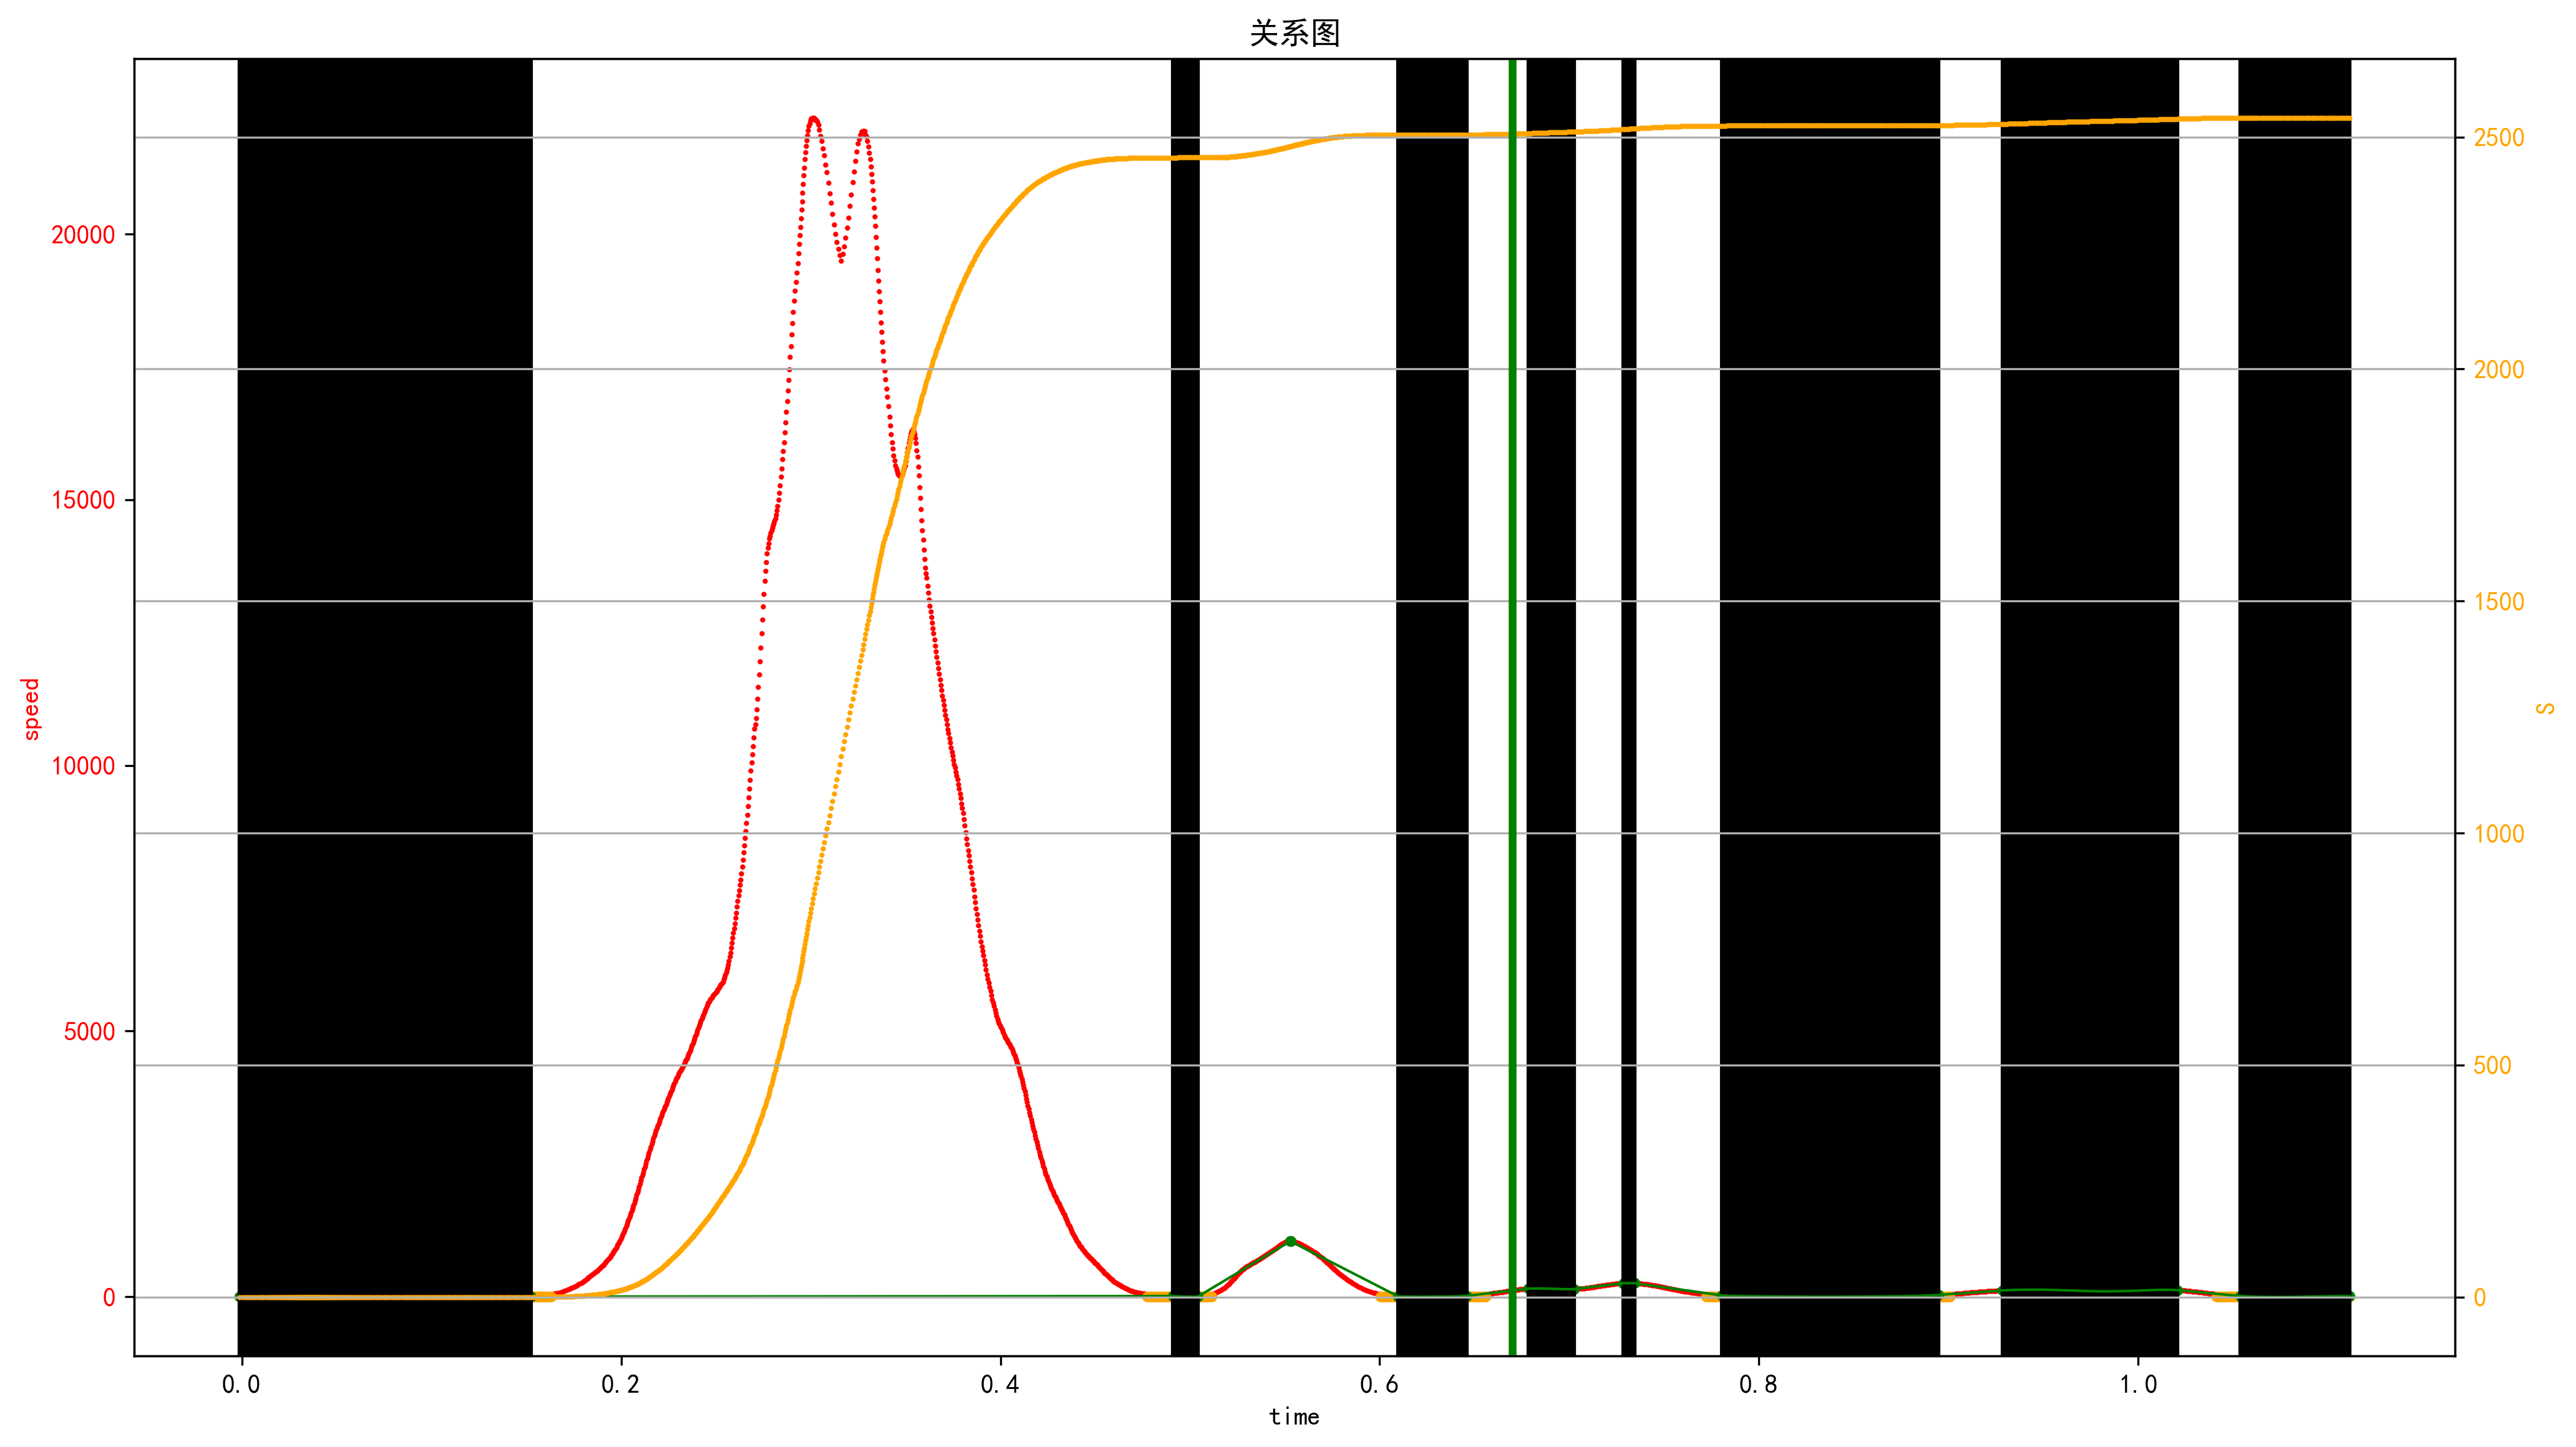

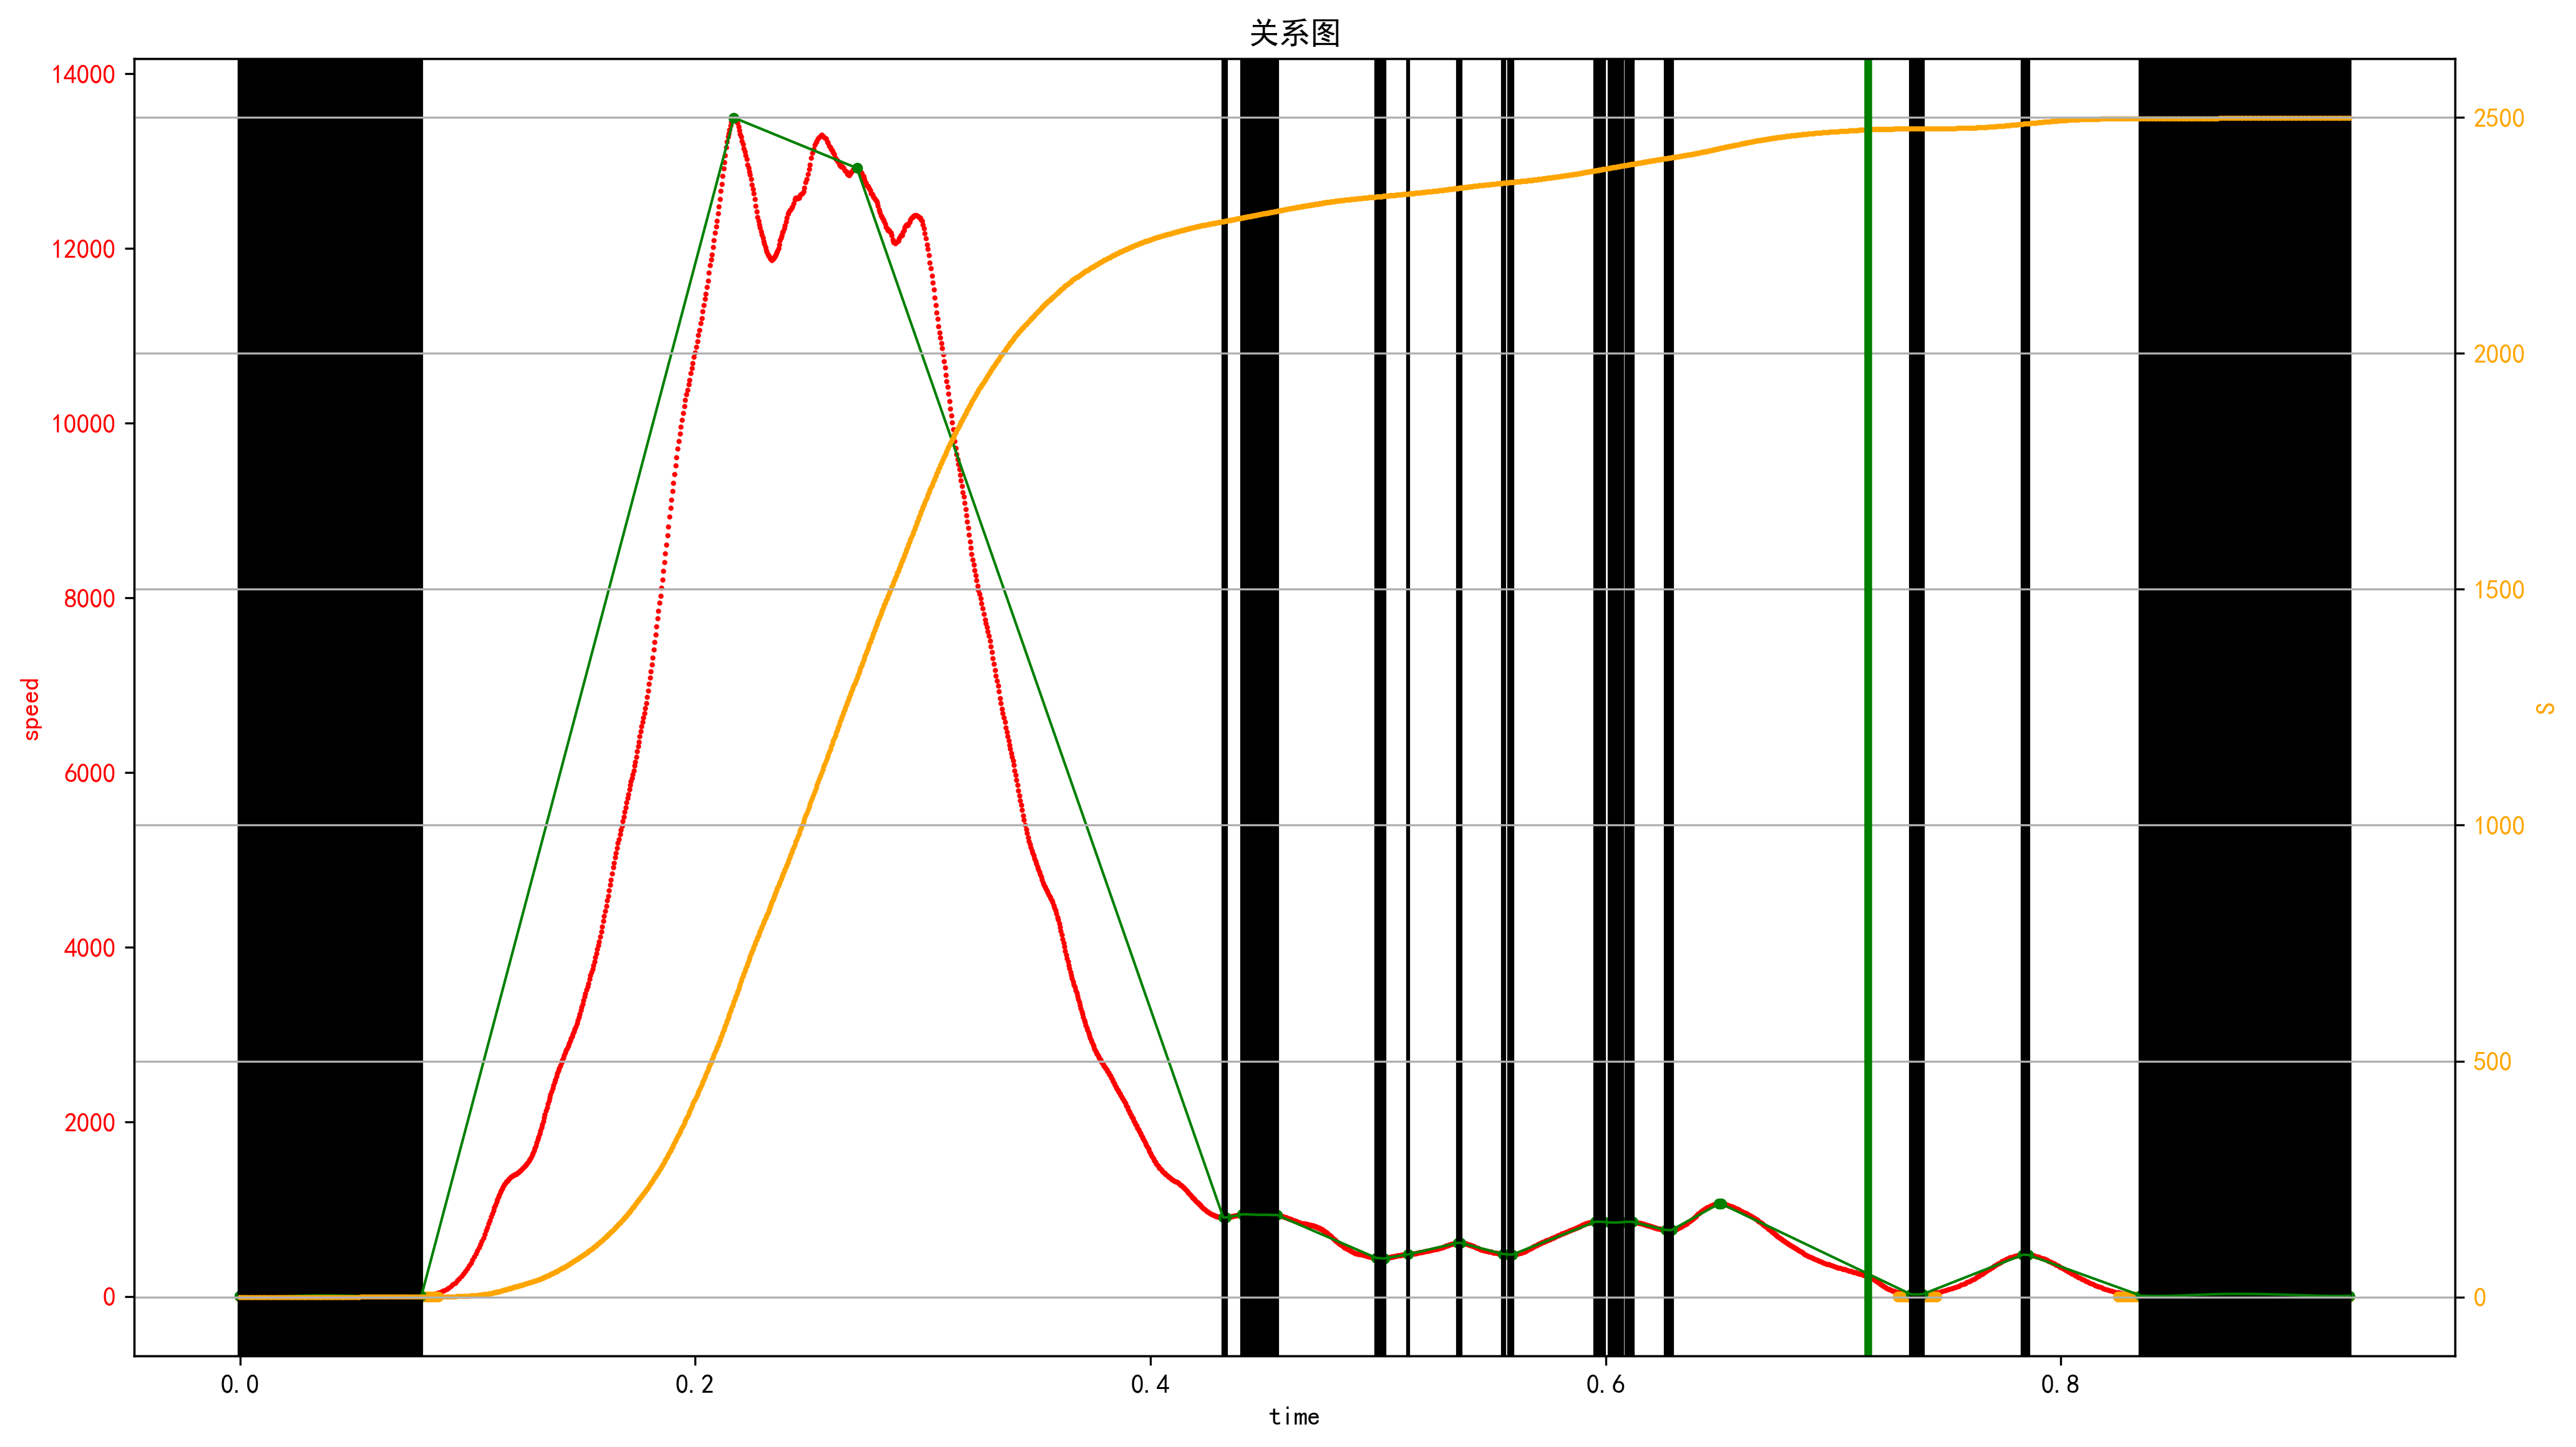

In [43]:
colors=[
    'red','orange','yellow','green','blue','purple','black',
]
for i in range(len(V_all_smoothed)):

    fig, ax1 = plt.subplots()
    fig.dpi=300
    fig.set_size_inches(16, 9)
    
    # 绘制原始数据和拟合曲线
    #ax1.set_xlim(0, 1.5)
    ax1.set_xlabel('time')
    ax1.set_ylabel('speed', color=colors[0])
    ax1.scatter(T_all[i], V_all_smoothed[i], color=colors[0],s=1)
    #ax1.scatter(T_all[i], S_all_smoothed[i], color='green',s=1)
    ax1.tick_params(axis='y', labelcolor=colors[0])
    #ax1.set_ylim(-1000,5000)
    
    for j in range(len(T_Ais0[i])):
        if V_Ais0[i][j]<1000:
            ax1.axvline(T_Ais0[i][j], color='black', linestyle='-')
            #pass
    
    
    ax1.scatter(T_Vis0[i], np.zeros(len(T_Vis0[i])), color=colors[1],s=10)
    ax1.scatter(T_Ais0[i], V_Ais0[i], color='green',s=10)
    ax1.plot(T_Ais0[i], V_Ais0[i], color='green',linewidth=1)
    
    
    ax2 = ax1.twinx()  # 创建共享X轴的第二个坐标轴

    ax2.set_ylabel('S', color=colors[1])
    ax2.scatter(T_all[i], S_all[i], color=colors[1],s=1)
    # 输出速度列表
    
    ax2.axvline(The_time_in_the_box[i], color='green', linestyle='-',linewidth=3)
    #ax2.set_ylim(-1000,5000)
    ax2.tick_params(axis='y', labelcolor=colors[1])
    for j in range(len(S_divide[i])):
        #ax2.axhline(S_divide[i][j], color=colors[j], linestyle='-',linewidth=1)
        pass
    
    plt.title('关系图')

    #plt.legend()
    plt.grid(True)
    plt.show()
    #break